In [20]:
import os
import pandas as pd
from wildlife_datasets import datasets
from wildlife_datasets.analysis import display_statistics
from wildlife_datasets import splits
import torchvision.transforms as T
import timm
from wildlife_tools.features import *
from wildlife_tools.data import ImageDataset
from wildlife_tools.similarity import CosineSimilarity
import numpy as np
from wildlife_tools.inference import KnnClassifier
import matplotlib.pyplot as plt
from PIL import Image  
import pickle
import yaml

In [21]:
# --- Load Configuration ---
with open('config.yml', 'r') as f:
    config = yaml.safe_load(f)

In [22]:
data_root = os.path.expanduser(config['paths']['data_root'])
image_dir = config['paths']['dataset_dir'].format(data_root=data_root)
manifest_file = config['paths']['merged_manifest_file'].format(data_root=data_root)
features_dir = config['paths']['features_dir'].format(data_root=data_root)

In [23]:
min_images = 1

In [24]:
class Horses(datasets.WildlifeDataset):
    def __init__(self, root_dir, manifest_file_path):
        self.manifest_file_path = manifest_file_path
        super().__init__(root_dir)

    def create_catalogue(self) -> pd.DataFrame:
        """Create catalogue from manifest file"""
        manifest_df = pd.read_csv(self.manifest_file_path)
        
        rows = []
        for _, row in manifest_df.iterrows():
            if 'status' in row and row['status'] == 'EXCLUDE':
                continue
            if 'num_horses_detected' in row and row['num_horses_detected'] in ['NONE', 'MULTIPLE']:
                continue

            # Parse segmentation mask from "x1 y1;x2 y2;..." format
            segmentation_data = None
            mask_str = row.get('segmentation_mask')
            if mask_str and pd.notna(mask_str) and isinstance(mask_str, str) and mask_str.strip():
                try:
                    # Parse the "x1 y1;x2 y2;..." format into a flat list [x1, y1, x2, y2, ...]
                    points = []
                    for point_str in mask_str.split(';'):
                        if ' ' in point_str:
                            x_str, y_str = point_str.strip().split()
                            points.extend([float(x_str), float(y_str)])
                    
                    if len(points) >= 6:  # At least 3 points for a valid polygon
                        segmentation_data = points  # Flat list format
                except (ValueError, IndexError) as e:
                    print(f"Warning: Failed to parse segmentation for {row['filename']}: {e}")
                    pass

            # Parse bbox data - now in pixel coordinates from detector
            bbox_data = None
            if all(col in row and pd.notna(row[col]) for col in ['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']):
                try:
                    # Bbox coordinates are already in pixel format from the detector
                    bbox_data = [
                        int(row['bbox_x']),
                        int(row['bbox_y']), 
                        int(row['bbox_width']),
                        int(row['bbox_height'])
                    ]
                except (ValueError, TypeError) as e:
                    print(f"Warning: Failed to parse bbox for {row['filename']}: {e}")
                    pass

            rows.append({
                'image_id': row['filename'],
                'identity': row['canonical_id'],
                'horse_name': row['horse_name'],
                'path': row['filename'],
                'date': pd.to_datetime(str(row['email_date']), format='%Y%m%d'),
                'segmentation': segmentation_data,
                'bbox': bbox_data,
            })
        
        # Create DataFrame from collected rows
        df = pd.DataFrame(rows)
        result = self.finalize_catalogue(df)
        return result

In [25]:
horses = Horses(image_dir,manifest_file_path=manifest_file)
horses_df = horses.create_catalogue()

Figure(640x480)


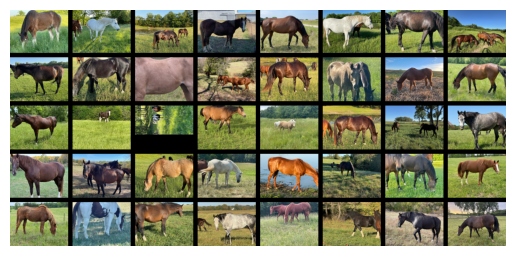

In [26]:
print(horses.plot_grid())

Number of identitites            233
Number of all animals            4069
Number of animals with one image 3
Number of unidentified animals   0
Images span                      3.0 years


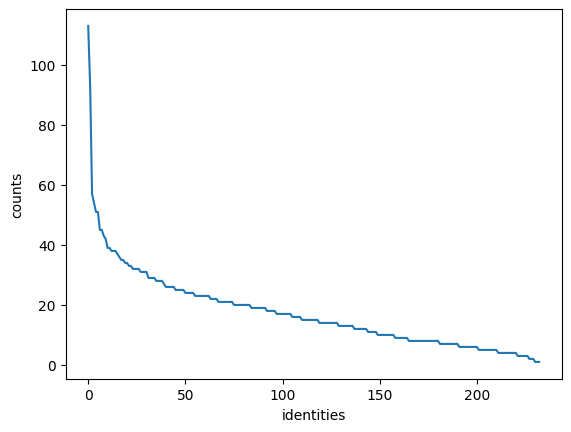

In [27]:
display_statistics(horses_df)

filter to include only those identities with > `min_images` images

In [28]:
horses_df = horses_df.groupby('identity').filter(lambda x: len(x) > min_images)

Number of identitites            230
Number of all animals            4066
Number of animals with one image 0
Number of unidentified animals   0
Images span                      3.0 years


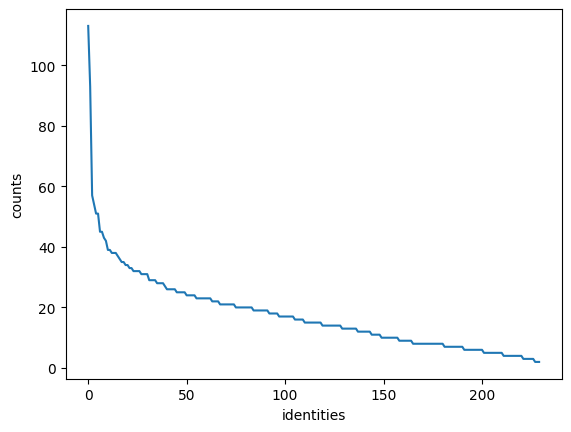

In [29]:
display_statistics(horses_df)

# Testing

Split the features into *query* and *database* sets

In [30]:
splitter = splits.ClosedSetSplit(0.5)
for idx_query, idx_database in splitter.split(horses_df):
    splits.analyze_split(horses_df, idx_query, idx_database)
    
df_query = horses_df.loc[idx_query]
df_database = horses_df.loc[idx_database]

transform = T.Compose([
    T.Resize([384, 384]), 
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

Split: time-unaware closed-set
Samples: train/test/unassigned/total = 2033/2033/0/4066
Classes: train/test/unassigned/total = 230/230/0/230
Samples: train only/test only        = 0/0
Classes: train only/test only/joint  = 0/0/230

Fraction of train set     = 50.00%
Fraction of test set only = 0.00%


## Extract features and compare

In [31]:
def extract_query_features_once(horses, df_query):
    """
    Extract query features once (always uses full images).
    Query features are the same regardless of database masking.
    """
    print("Extracting query features (full images, done once)...")
    
    horses_query = Horses(image_dir, manifest_file_path=manifest_file)
    horses_query.df = df_query
    horses_query.transform = transform
    horses_query.img_load = "full"  # Always full for queries
    horses_query.load_label = True
    dataset_query = horses_query

    extractor = DeepFeatures(timm.create_model('hf-hub:BVRA/wildlife-mega-L-384', pretrained=True), num_workers=0)
    query_features = extractor(dataset_query)
    
    return query_features, dataset_query

def extract_database_features_for_mask(horses, df_database, mask):
    """
    Extract database features for a specific mask type.
    """
    print(f"  Extracting database features for mask: {mask}")
    
    horses_database = Horses(image_dir, manifest_file_path=manifest_file)
    horses_database.df = df_database
    horses_database.transform = transform
    horses_database.img_load = mask  # Apply specified mask
    horses_database.load_label = True
    dataset_database = horses_database

    extractor = DeepFeatures(timm.create_model('hf-hub:BVRA/wildlife-mega-L-384', pretrained=True), num_workers=0)
    database_features = extractor(dataset_database)
    
    return database_features, dataset_database

In [32]:
def run_knn_evaluation(query_features, database_features, dataset_query, dataset_database, mask_name):
    """
    Run KNN evaluation using pre-extracted features.
    """
    print(f"\n--- KNN Evaluation (mask: {mask_name}) ---")
    
    # Calculate similarity
    similarity_function = CosineSimilarity()
    similarity = similarity_function(query_features, database_features)
    
    # Evaluate with KNN
    classifier = KnnClassifier(k=1, database_labels=dataset_database.labels_string)
    predictions = classifier(similarity)
    accuracy = np.mean(dataset_query.labels_string == predictions)
    
    print(f"KNN accuracy: {accuracy:.4f}")
    return accuracy

In [33]:
def run_topk_evaluation(query_features, database_features, dataset_query, dataset_database, mask_name, k_values=[1, 3, 5, 10, 20]):
    """
    Run Top-K evaluation using pre-extracted features.
    """
    print(f"\n--- Top-K Evaluation (mask: {mask_name}) ---")
    
    # Calculate Top-K accuracy
    topk_results = calculate_topk_accuracy(
        query_features=query_features,
        database_features=database_features,
        query_labels=dataset_query.labels_string,
        database_labels=dataset_database.labels_string,
        k_values=k_values
    )
    
    # Detailed analysis
    print(f"\nDetailed Analysis (mask: {mask_name}):")
    detailed_results = detailed_evaluation_analysis(
        query_features=query_features,
        database_features=database_features,
        query_labels=dataset_query.labels_string,
        database_labels=dataset_database.labels_string
    )
    
    return {
        'topk_accuracy': topk_results,
        'detailed_analysis': detailed_results,
        'mask_type': mask_name
    }

In [34]:
def calculate_topk_accuracy(query_features, database_features, query_labels, database_labels, k_values=[1, 3, 5, 10]):
    """
    Calculate Top-K accuracy for different values of K.
    
    Args:
        query_features: Features for query images
        database_features: Features for database images  
        query_labels: True labels for query images
        database_labels: Labels for database images
        k_values: List of K values to evaluate
    
    Returns:
        Dictionary with Top-K accuracy scores
    """
    from wildlife_tools.inference import TopkClassifier
    from wildlife_tools.similarity import CosineSimilarity
    
    similarity_function = CosineSimilarity()
    similarity = similarity_function(query_features, database_features)
    
    results = {}
    
    for k in k_values:
        classifier = TopkClassifier(k=k, database_labels=database_labels, return_all=True)
        predictions, scores, indices = classifier(similarity)
        
        correct_predictions = 0
        total_predictions = len(query_labels)
        
        for i, (query_label, top_k_preds) in enumerate(zip(query_labels, predictions)):
            # Check if the true label is in the top-k predictions
            if query_label in top_k_preds:
                correct_predictions += 1
        
        accuracy = correct_predictions / total_predictions
        results[f'top_{k}_accuracy'] = accuracy
        
        print(f"Top-{k} Accuracy: {accuracy:.1%} ({correct_predictions}/{total_predictions})")
    
    return results

In [35]:
def detailed_evaluation_analysis(query_features, database_features, query_labels, database_labels):
    """
    Provide detailed analysis of identification performance.
    """
    from wildlife_tools.inference import TopkClassifier
    from wildlife_tools.similarity import CosineSimilarity
    
    similarity_function = CosineSimilarity()
    similarity = similarity_function(query_features, database_features)
    
    classifier = TopkClassifier(k=10, database_labels=database_labels, return_all=True)
    predictions, scores, indices = classifier(similarity)
    
    # Analyze confidence scores for correct vs incorrect predictions
    correct_scores = []
    incorrect_scores = []
    
    for i, (query_label, top_preds, top_scores) in enumerate(zip(query_labels, predictions, scores)):
        if query_label == top_preds[0]:  # Top-1 correct
            correct_scores.append(top_scores[0])
        else:
            incorrect_scores.append(top_scores[0])
    
    if correct_scores:
        print(f"Average confidence for correct Top-1: {np.mean(correct_scores):.3f}")
    if incorrect_scores:
        print(f"Average confidence for incorrect Top-1: {np.mean(incorrect_scores):.3f}")
    
    # Distribution of where correct answer appears in rankings
    rank_distribution = {}
    for i, (query_label, top_preds) in enumerate(zip(query_labels, predictions)):
        if query_label in top_preds:
            rank = list(top_preds).index(query_label) + 1
            rank_distribution[rank] = rank_distribution.get(rank, 0) + 1
        else:
            rank_distribution['not_found'] = rank_distribution.get('not_found', 0) + 1
    
    print("\nRank distribution of correct answers:")
    for rank in sorted([k for k in rank_distribution.keys() if k != 'not_found']):
        print(f"  Rank {rank}: {rank_distribution[rank]} queries")
    if 'not_found' in rank_distribution:
        print(f"  Not in Top-10: {rank_distribution['not_found']} queries")
    
    return {
        'correct_scores': correct_scores,
        'incorrect_scores': incorrect_scores,
        'rank_distribution': rank_distribution
    }

### Extract features from query dataset

In [36]:
# Extract query features once (always full images)
query_features, dataset_query = extract_query_features_once(horses, df_query)


Extracting query features (full images, done once)...


100%|███████████████████████████████████████████████████████████████| 16/16 [12:00<00:00, 45.05s/it]


In [37]:
all_results = {}

In [38]:
#mask_types = ["full", "bbox", "bbox_mask"]

def evaluate_mask_type(horses, df_database, query_features, mask_type):
    print(f"\n{'='*60}")
    print(f"EVALUATING DATABASE MASK TYPE: {mask_type.upper()}")
    print(f"{'='*60}")
    
    # Extract database features for this mask type only
    database_features, dataset_database = extract_database_features_for_mask(
        horses, df_database, mask_type
    )
    
    # Run KNN evaluation (reusing query features)
    knn_accuracy = run_knn_evaluation(
        query_features, database_features, dataset_query, dataset_database, mask_type
    )
    
    # Run Top-K evaluation (reusing query features)
    topk_results = run_topk_evaluation(
        query_features, database_features, dataset_query, dataset_database, mask_type
    )
    
    # retrun results
    return {
        'knn_accuracy': knn_accuracy,
        'topk_results': topk_results
    }

In [39]:
mask = "full"
all_results[mask] = evaluate_mask_type(horses, df_database, query_features, mask)


EVALUATING DATABASE MASK TYPE: FULL
  Extracting database features for mask: full


100%|███████████████████████████████████████████████████████████████| 16/16 [12:36<00:00, 47.28s/it]



--- KNN Evaluation (mask: full) ---
KNN accuracy: 0.6276

--- Top-K Evaluation (mask: full) ---
Top-1 Accuracy: 62.9% (1279/2033)
Top-3 Accuracy: 71.9% (1462/2033)
Top-5 Accuracy: 75.1% (1526/2033)
Top-10 Accuracy: 80.5% (1636/2033)
Top-20 Accuracy: 84.8% (1723/2033)

Detailed Analysis (mask: full):
Average confidence for correct Top-1: 0.796
Average confidence for incorrect Top-1: 0.642

Rank distribution of correct answers:
  Rank 1: 1279 queries
  Rank 2: 130 queries
  Rank 3: 53 queries
  Rank 4: 36 queries
  Rank 5: 28 queries
  Rank 6: 23 queries
  Rank 7: 25 queries
  Rank 8: 26 queries
  Rank 9: 16 queries
  Rank 10: 20 queries
  Not in Top-10: 397 queries


In [40]:
mask = "bbox"
all_results[mask] = evaluate_mask_type(horses, df_database, query_features, mask)


EVALUATING DATABASE MASK TYPE: BBOX
  Extracting database features for mask: bbox


100%|███████████████████████████████████████████████████████████████| 16/16 [12:22<00:00, 46.41s/it]



--- KNN Evaluation (mask: bbox) ---
KNN accuracy: 0.6099

--- Top-K Evaluation (mask: bbox) ---
Top-1 Accuracy: 60.9% (1239/2033)
Top-3 Accuracy: 69.9% (1421/2033)
Top-5 Accuracy: 72.9% (1483/2033)
Top-10 Accuracy: 78.6% (1598/2033)
Top-20 Accuracy: 84.5% (1717/2033)

Detailed Analysis (mask: bbox):
Average confidence for correct Top-1: 0.708
Average confidence for incorrect Top-1: 0.517

Rank distribution of correct answers:
  Rank 1: 1239 queries
  Rank 2: 124 queries
  Rank 3: 58 queries
  Rank 4: 30 queries
  Rank 5: 32 queries
  Rank 6: 33 queries
  Rank 7: 20 queries
  Rank 8: 20 queries
  Rank 9: 19 queries
  Rank 10: 23 queries
  Not in Top-10: 435 queries


In [41]:
mask = "bbox_mask"
all_results[mask] = evaluate_mask_type(horses, df_database, query_features, mask)


EVALUATING DATABASE MASK TYPE: BBOX_MASK
  Extracting database features for mask: bbox_mask


100%|███████████████████████████████████████████████████████████████| 16/16 [13:49<00:00, 51.86s/it]



--- KNN Evaluation (mask: bbox_mask) ---
KNN accuracy: 0.2164

--- Top-K Evaluation (mask: bbox_mask) ---
Top-1 Accuracy: 21.6% (440/2033)
Top-3 Accuracy: 33.7% (686/2033)
Top-5 Accuracy: 40.1% (815/2033)
Top-10 Accuracy: 49.3% (1002/2033)
Top-20 Accuracy: 61.0% (1241/2033)

Detailed Analysis (mask: bbox_mask):
Average confidence for correct Top-1: 0.367
Average confidence for incorrect Top-1: 0.319

Rank distribution of correct answers:
  Rank 1: 440 queries
  Rank 2: 144 queries
  Rank 3: 102 queries
  Rank 4: 73 queries
  Rank 5: 56 queries
  Rank 6: 48 queries
  Rank 7: 47 queries
  Rank 8: 33 queries
  Rank 9: 28 queries
  Rank 10: 31 queries
  Not in Top-10: 1031 queries


In [42]:
# Display comprehensive results comparison
def display_comprehensive_results(all_results):
    """
    Display both KNN and Top-K results in a comprehensive comparison.
    """
    print(f"\n{'='*80}")
    print("COMPREHENSIVE EVALUATION RESULTS")
    print(f"{'='*80}")
    
    # KNN Results Table
    print(f"\nKNN ACCURACY (k=1) COMPARISON:")
    print("-" * 40)
    print(f"{'Mask Type':<15} {'KNN Accuracy':<15}")
    print("-" * 40)
    for mask_type, results in all_results.items():
        knn_acc = results['knn_accuracy']
        print(f"{mask_type:<15} {knn_acc:.1%}")
    
    # Top-K Results Table
    print(f"\nTOP-K ACCURACY COMPARISON:")
    print("-" * 80)
    k_values = [1, 3, 5, 10, 20]
    header = f"{'Mask Type':<15} " + " ".join([f"Top-{k:>2}" for k in k_values])
    print(header)
    print("-" * 80)
    
    for mask_type, results in all_results.items():
        topk_accuracies = results['topk_results']['topk_accuracy']
        accuracy_strs = []
        for k in k_values:
            key = f'top_{k}_accuracy'
            if key in topk_accuracies:
                accuracy_strs.append(f"{topk_accuracies[key]:.1%}")
            else:
                accuracy_strs.append("  N/A")
        print(f"{mask_type:<15} " + " ".join([f"{acc:>5}" for acc in accuracy_strs]))
    
    print(f"\nKEY INSIGHTS:")
    print("- Top-1 accuracy should match KNN k=1 accuracy")
    print("- Top-5 accuracy is most relevant for production system")
    print("- Higher Top-K values show system's recovery potential")
    print("- Compare masking effects on both KNN and Top-K performance")

# Display results
display_comprehensive_results(all_results)


COMPREHENSIVE EVALUATION RESULTS

KNN ACCURACY (k=1) COMPARISON:
----------------------------------------
Mask Type       KNN Accuracy   
----------------------------------------
full            62.8%
bbox            61.0%
bbox_mask       21.6%

TOP-K ACCURACY COMPARISON:
--------------------------------------------------------------------------------
Mask Type       Top- 1 Top- 3 Top- 5 Top-10 Top-20
--------------------------------------------------------------------------------
full            62.9% 71.9% 75.1% 80.5% 84.8%
bbox            60.9% 69.9% 72.9% 78.6% 84.5%
bbox_mask       21.6% 33.7% 40.1% 49.3% 61.0%

KEY INSIGHTS:
- Top-1 accuracy should match KNN k=1 accuracy
- Top-5 accuracy is most relevant for production system
- Higher Top-K values show system's recovery potential
- Compare masking effects on both KNN and Top-K performance


## Production System Alignment

The Top-5 accuracy metric directly corresponds to how often users receive the correct horse identification in the 5 results returned by the production system (`horse_id.py` uses `k=5`).